Natural Language Processing (NLP) is a core subfield of machine learning concerned with programming computers to process and analyze large amounts of natural language data. Some common challenges within NLP include speech recognition, text generation, sentiment analysis, and more, and some high-profile products deploying NLP models include Siri, Alexa, and many of the chatbots you interact with on websites. 

To learn how to use Comet in your NLP workflow, follow along below as we work through predicting the sentiment of tweets about US Airlines, using the popular Twitter US Airline Sentiment dataset. 

In [1]:
%matplotlib inline


# Comet
import comet_ml
from comet_ml import Experiment 

# Standard packages
import os
import pickle
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# nltk for preprocessing of text data
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# sklearn for preprocessing and machine learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# XGBoost for Machine Learning (Gradient Boosting Machine (GBM))
import xgboost as xgb

# Keras for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Random seeds for consistent results
from tensorflow import set_random_seed
seed = 1234
np.random.seed(seed)
set_random_seed(seed)

Using TensorFlow backend.


In [2]:
DATA = '/Users/nikolaskaris/Desktop/twitter-airline-sentiment/'

In [3]:
print('\n# Files and file sizes')
for file in os.listdir(DATA):
    print('{} | {} MB'.format(file.ljust(30), str(round(os.path.getsize(DATA + file) / 1000000, 2))))


# Files and file sizes
database.sqlite                | 5.04 MB
.DS_Store                      | 0.01 MB
Tweets.csv                     | 3.42 MB


In [10]:
raw_df = pd.read_csv(f'{DATA}Tweets.csv')
print('Raw Dataframe:')
raw_df.head()

Raw Dataframe:


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
raw_df = raw_df.drop(['tweet_coord', 'airline_sentiment_gold', 'negativereason_gold'], axis=1)

In [5]:

# import six
# def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
#                      header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
#                      bbox=[0, 0, 1, 1], header_columns=0,
#                      ax=None, **kwargs):
#     if ax is None:
#         size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
#         fig, ax = plt.subplots(figsize=size)
#         ax.axis('off')

#     mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

#     mpl_table.auto_set_font_size(False)
#     mpl_table.set_fontsize(font_size)

#     for k, cell in six.iteritems(mpl_table._cells):
#         cell.set_edgecolor(edge_color)
#         if k[0] == 0 or k[1] < header_columns:
#             cell.set_text_props(weight='bold', color='w')
#             cell.set_facecolor(header_color)
#         else:
#             cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
#     return ax

In [5]:
os.chdir('/Users/nikolaskaris/Desktop/twitter-airline-sentiment/')

In [6]:
raw_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
# render_mpl_table(raw_df.head(), header_columns=0, col_width=3.0)

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


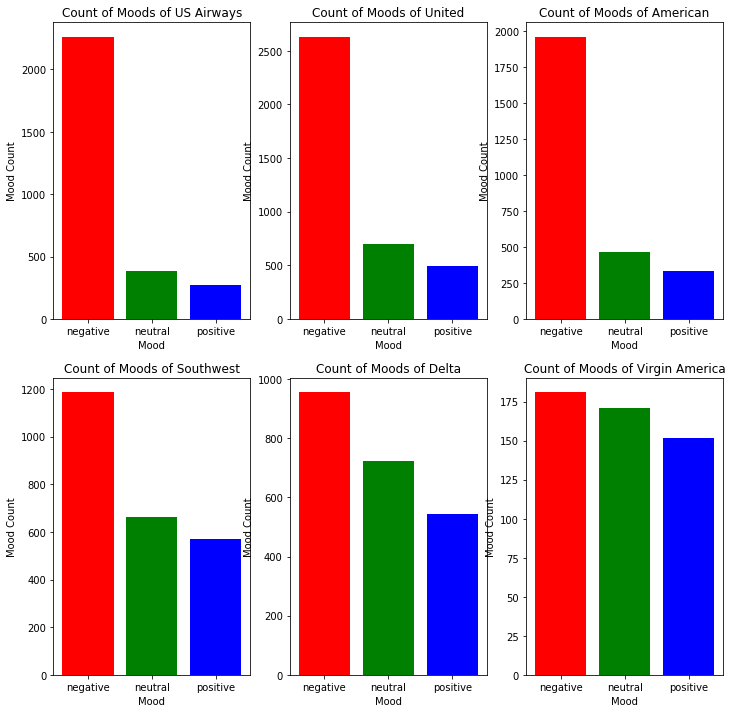

In [9]:
print("Total number of tweets for each airline \n ", raw_df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=raw_df[raw_df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

In [12]:
# Select features
df = raw_df[['tweet_id', 'text', 'airline_sentiment']]
print('Feature selected DataFrame:')
df.head(10)

Feature selected DataFrame:


,tweet_id,text,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative
5,570300767074181121,@VirginAmerica seriously would pay $30 a fligh...,negative
6,570300616901320704,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,570300248553349120,@VirginAmerica Really missed a prime opportuni...,neutral
8,570299953286942721,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,570295459631263746,"@VirginAmerica it was amazing, and arrived an ...",positive


In [28]:
df['text'][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

In [29]:
df['text'][750]

'@united you are offering us 8 rooms for 32 people #FAIL'

In [30]:
df['text'][5800]

"@SouthwestAir Your #Android Wi-Fi experience is terrible! $8 is a ripoff! I can't get to @NASCAR or MRN for @DISupdates #BudweiserDuels"

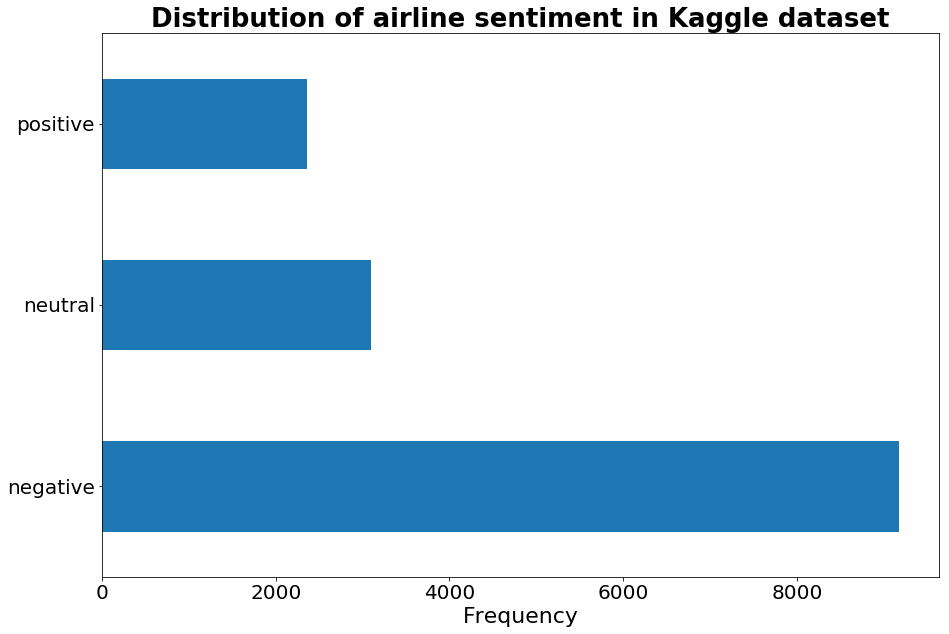

In [12]:
# Plot sentiment distribution
df['airline_sentiment'].value_counts().plot(kind = 'barh',
                                            figsize = (15,10));
plt.title('Distribution of airline sentiment in Kaggle dataset', 
          fontsize = 26, weight = 'bold')
plt.xlabel('Frequency', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

In [13]:
class PreProcessor:
    '''
    Easily performs all the standard preprocessing steps
    like removing stopwords, stemming, etc.
    Only input that you need to provide is the dataframe and column name for the tweets
    '''
    def __init__(self, df, column_name):
        self.data = df
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []
        
    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence
            
    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https': 
                filtered_sentence.append(w)
        return filtered_sentence
    
    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get truncated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]
    
    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)
    
    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)
            
        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.preprocessed

In [14]:
# Preprocess text and put it in a new column
preprocessor = PreProcessor(df, 'text')
df['cleaned_text'] = preprocessor.full_preprocess()

/Users/nikolaskaris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Shuffling so we can get random tweets for the test set
df = shuffle(df, random_state=seed)
# Keep 1000 samples of the data as test set
test_set = df[:1000]

In [10]:
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_text'][1000:], 
                                                  df['airline_sentiment'][1000:], 
                                                  test_size=0.2, 
                                                  random_state=seed)

# Get sentiment labels for test set
y_test = test_set['airline_sentiment']


In [11]:
# Create matrix based on word frequency in tweets
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['cleaned_text'])


In [12]:
# Print the size of our data
print(f'Training size: {X_train.shape[0]} tweets\n\
Validation size: {X_val.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')


Training size: 10912 tweets
Validation size: 2728 tweets
Test size: 1000 tweets
Amount of words (columns): 9672 words


## Initialize Comet Experiment

## LGBM

In [32]:
experiment = Experiment(api_key="ERPBfa6mmwJzQnk61oiqLOCie",
                        project_name="nlp-airline", workspace="demo")
experiment.add_tag('LGBM')
# sklearn's Gradient Boosting Classifier (GBM)
gbm = GradientBoostingClassifier(n_estimators=200, 
                                 max_depth=6, 
                                 random_state=seed)
gbm.fit(X_train, y_train)
# Check results
train_pred = gbm.predict(X_train)
val_pred = gbm.predict(X_val)
print(f'Accuracy on training set (GBM): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (GBM): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

val_accuracy = round(accuracy_score(y_val,val_pred)*100, 4)
train_accuracy = round(accuracy_score(y_train, train_pred)*100, 4)

# log to comet
experiment.log_metric('val_acc', val_accuracy)
experiment.log_metric('Accuracy', train_accuracy)
experiment.end()

COMET INFO: old comet version (2.0.7) detected. current: 2.0.8 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/demo/nlp-airline/f112da082ad24200bc566553af78684f

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/demo/nlp-airline/f112da082ad24200bc566553af78684f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy: (87.4267, 87.4267)
COMET INFO:     val_acc : (76.7229, 76.7229)
COMET INFO: ----------------------------
COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


Accuracy on training set (GBM): 87.4267%
Accuracy on validation set (GBM): 76.7229%


## XGBOOST

In [30]:
# experiment = Experiment(api_key="ERPBfa6mmwJzQnk61oiqLOCie",
#                         project_name="nlp-airline", workspace="demo")
# experiment.add_tag('XGBOOST')
# # Hyperparameters that you can tweak
# # There are a lot more tweakable hyperparameters that you can find at 
# # https://xgboost.readthedocs.io/en/latest/parameter.html
# xgb_params = {'objective' : 'multi:softmax',
#               'eval_metric' : 'mlogloss',
#               'eta' : 0.1,
#               'max_depth' : 6,
#               'num_class' : 3,
#               'lambda' : 0.8,
#               'estimators' : 200,
#               'seed' : seed
              
# }

# # Transform categories into numbers
# # negative = 0, neutral = 1 and positive = 2
# target_train = y_train.astype('category').cat.codes
# target_val = y_val.astype('category').cat.codes

# # Transform data into a matrix so that we can use XGBoost
# d_train = xgb.DMatrix(X_train, label = target_train)
# d_val = xgb.DMatrix(X_val, label = target_val)

# # Fit XGBoost
# watchlist = [(d_train, 'train'), (d_val, 'validation')]
# bst = xgb.train(xgb_params, 
#                 d_train, 
#                 400,  
#                 watchlist,
#                 early_stopping_rounds = 50, 
#                 verbose_eval = 0)

# # Check results for XGBoost
# train_pred = bst.predict(d_train)
# val_pred = bst.predict(d_val)
# print(f'Accuracy on training set (XGBoost): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
# print(f'Accuracy on validation set (XGBoost): {round(accuracy_score(target_val, val_pred)*100, 4)}%')
# experiment.end()

COMET INFO: old comet version (2.0.7) detected. current: 2.0.8 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/demo/nlp-airline/69c39161cab8456383e7ef31dd64b852

/Users/nikolaskaris/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/nikolaskaris/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/demo/nlp-airline/69c39161cab8456383e7ef31dd64b852
COMET INFO: ----------------------------
COMET INFO: Uploading stats to Comet before program termination (m

Accuracy on training set (XGBoost): 89.5803%
Accuracy on validation set (XGBoost): 77.3827%


## Neural Net

In [26]:
# Generator so we can easily feed batches of data to the neural network
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [27]:
# Onehot encoding of target variable
# Negative = [1,0,0], Neutral = [0,1,0], Positive = [0,0,1]

# Initialize sklearn's one-hot encoder class
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = np.array(y_train).reshape(len(y_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = np.array(y_val).reshape(len(y_val), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

In [29]:
# experiment = Experiment(api_key="ERPBfa6mmwJzQnk61oiqLOCie",
#                         project_name="nlp-airline", workspace="demo")
# experiment.add_tag('NN')
# # Neural network architecture
# initializer = keras.initializers.he_normal(seed=seed)
# activation = keras.activations.elu
# optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)

# # Build model architecture
# model = Sequential()
# model.add(Dense(20, activation=activation, kernel_initializer=initializer, input_dim=X_train.shape[1]))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation='softmax', kernel_initializer=initializer))
# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Hyperparameters
# epochs = 15
# batch_size = 16

# # Fit the model using the batch_generator
# hist = model.fit_generator(generator=batch_generator(X_train, onehot_encoded_train, batch_size=batch_size, shuffle=True),
#                            epochs=epochs, validation_data=(X_val, onehot_encoded_val),
#                            steps_per_epoch=X_train.shape[0]/batch_size, callbacks=[es])

# experiment.end()

Epoch 1/15
682/682 [==============================] - 2s 4ms/step - loss: 0.5522 - acc: 0.7268 - val_loss: 0.4893 - val_acc: 0.7757
Epoch 2/15
682/682 [==============================] - 2s 3ms/step - loss: 0.4753 - acc: 0.7832 - val_loss: 0.4443 - val_acc: 0.7995
Epoch 3/15
682/682 [==============================] - 2s 4ms/step - loss: 0.4276 - acc: 0.8112 - val_loss: 0.4073 - val_acc: 0.8193
Epoch 4/15
682/682 [==============================] - 2s 3ms/step - loss: 0.3868 - acc: 0.8307 - val_loss: 0.3795 - val_acc: 0.8282
Epoch 5/15
682/682 [==============================] - 3s 4ms/step - loss: 0.3525 - acc: 0.8455 - val_loss: 0.3594 - val_acc: 0.8415
Epoch 6/15
 80/682 [==>...........................] - ETA: 1s - loss: 0.3239 - acc: 0.8630

KeyboardInterrupt: 